Same purpose as data-prep.ipynb, but mean for daily data interval

Import ONI data

In [49]:
import pandas as pd
import os
import numpy as np

oni_data = pd.read_csv("oni.txt", sep="\s+")
oni_data

,YR,MON,TOTAL,ClimAdjust,ANOM
0,1950,1,24.56,26.18,-1.62
1,1950,2,25.07,26.39,-1.32
2,1950,3,25.88,26.95,-1.07
3,1950,4,26.29,27.39,-1.11
4,1950,5,26.19,27.56,-1.37
...,...,...,...,...,...
893,2024,6,27.91,27.73,0.18
894,2024,7,27.34,27.29,0.05
895,2024,8,26.74,26.86,-0.11
896,2024,9,26.47,26.72,-0.25


Import DID/MET data

In [50]:
import pandas as pd
import os
import re
folder_path = "bintulu"
precipitation_data = pd.DataFrame()
for file in os.listdir(folder_path):
    if re.search(r"daily-rainfall-data\d*\.csv", file):
        df = pd.read_csv(f"{folder_path}/{file}")
        precipitation_data = pd.concat([precipitation_data, df], ignore_index=True)
    else:
        continue

In [51]:
precipitation_data["DateTime"] = pd.to_datetime(precipitation_data["DateTime"],format="%d/%m/%Y")
precipitation_data = precipitation_data[["DateTime", "Rainfall (mm)"]]
precipitation_data.rename(columns={"Rainfall (mm)": "Rainfall"}, inplace=True)

In [52]:
if (precipitation_data['Rainfall'] < 0).any():
    # Forward fill the negative data
    precipitation_data['Rainfall'] = precipitation_data['Rainfall'].mask(precipitation_data['Rainfall'] < 0).ffill()

print(precipitation_data.Rainfall.loc[precipitation_data.Rainfall < 0])
precipitation_data

Series([], Name: Rainfall, dtype: float64)


,DateTime,Rainfall
0,2012-01-01,55.4
1,2012-01-02,1.2
2,2012-01-03,3.4
3,2012-01-04,4.2
4,2012-01-05,88.0
...,...,...
3648,2021-12-27,0.8
3649,2021-12-28,0.0
3650,2021-12-29,0.6
3651,2021-12-30,0.6


Merge DID and ONI data

In [53]:
precipitation_data = pd.merge(
    precipitation_data,
    oni_data[["YR", "MON", "TOTAL", "ClimAdjust", "ANOM"]],
    left_on=[precipitation_data["DateTime"].dt.year, precipitation_data["DateTime"].dt.month],
    right_on= ["YR", "MON"]
).drop(["YR", "MON"], axis=1)
precipitation_data.set_index("DateTime",inplace=True)

precipitation_data


,Rainfall,TOTAL,ClimAdjust,ANOM
DateTime,,,,
2012-01-01,55.4,25.68,26.55,-0.87
2012-01-02,1.2,25.68,26.55,-0.87
2012-01-03,3.4,25.68,26.55,-0.87
2012-01-04,4.2,25.68,26.55,-0.87
2012-01-05,88.0,25.68,26.55,-0.87
...,...,...,...,...
2021-12-27,0.8,25.54,26.60,-1.06
2021-12-28,0.0,25.54,26.60,-1.06
2021-12-29,0.6,25.54,26.60,-1.06


Import Wunderground data

In [54]:
feature_data = pd.read_csv(f"{folder_path}/rainfall-feature-wunderground.csv")
feature_data.rename(columns={"Time":"DateTime"},inplace=True)
feature_data["DateTime"] = pd.to_datetime(feature_data["DateTime"], format="%Y-%m-%d %H:%M:%S%z")
feature_data["DateTime"] = feature_data["DateTime"].dt.tz_localize(None)
feature_data.set_index("DateTime",inplace=True)
# feature_data.drop(columns={"Wind Gust", "Precip."}, inplace=True)
feature_data.fillna({"Wind Speed":0}, inplace=True)
feature_data.ffill(inplace=True)
feature_data.rename(columns={"Dew Point": "DewPoint", "Wind Speed": "WindSpeed", "Wind Direction": "WindDir"}, inplace=True)
feature_data

,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir
DateTime,,,,,,,
2012-01-01 00:00:00,79,77,94,6.0,3.0,29.87,110.0
2012-01-01 01:00:00,79,77,94,6.0,2.0,29.84,100.0
2012-01-01 02:00:00,79,77,94,6.0,1.0,29.84,60.0
2012-01-01 03:00:00,77,77,100,6.0,2.0,29.81,140.0
2012-01-01 04:00:00,77,77,100,6.0,3.0,29.81,90.0
...,...,...,...,...,...,...,...
2021-12-31 19:00:00,82,75,79,6.0,3.0,29.71,360.0
2021-12-31 20:00:00,81,75,84,6.0,2.0,29.74,360.0
2021-12-31 21:00:00,79,75,89,6.0,2.0,29.77,360.0


In [55]:
def resultant_wind_direction(x):
    radians = np.deg2rad(x)

    mean_sin = np.mean(np.sin(radians))
    mean_cos = np.mean(np.cos(radians))

    resultant_radians = np.arctan2(mean_sin, mean_cos)
    resultant_degrees = np.rad2deg(resultant_radians) % 360
    
    return resultant_degrees



topo_loc = {
    "lawas":
    {
        "lat": 4.847301, "lon": 115.406703, "elev": 6.5,
    },
    "mulu":
    {
        "lat": 4.049213, "lon": 114.810996, "elev": 28.7,
    },
    "kuching":
    {
        "lat": 1.487123, "lon": 110.341599, "elev": 22.3,
    },
    "kota-kinabalu":
    {
        "lat": 5.923283, "lon": 116.051239, "elev": 5.4,
    },
    "kuantan":
    {
        "lat": 3.780726, "lon": 103.215062, "elev": 16,
    },
    "miri":
    {
        "lat": 4.322991, "lon": 113.987416, "elev": 19,
    },
    "bintulu":
    {
        "lat": 3.120846, "lon": 113.024487, "elev": 24,
    },
}


In [56]:
daily_feature_data = feature_data.resample('D').agg({
    'Temperature': 'mean',
    'DewPoint': 'mean',
    # 'Temperature': lambda x: (x - 32) * 5/9,
    # 'DewPoint': lambda x: (x - 32) * 5/9,
    'Humidity': 'mean',
    'Visibility': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean',
    'WindDir': resultant_wind_direction
})

# Add location information from topo_loc
daily_feature_data['Latitude'] = topo_loc[folder_path]['lat']
daily_feature_data['Longitude'] = topo_loc[folder_path]['lon']
daily_feature_data['Elevation'] = topo_loc[folder_path]['elev']

Combine all data

In [57]:
weather_data = ['DateTime','Rainfall','TOTAL','ClimAdjust','ANOM','Temperature','DewPoint','Humidity','Visibility','WindSpeed','Pressure','WindDir','Latitude','Longitude','Elevation']
weather_data = precipitation_data.join(daily_feature_data)
# lawas_rainfall.dropna(inplace=True)
weather_data

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2012-01-01,55.4,25.68,26.55,-0.87,81.130435,77.434783,89.043478,6.000000,4.043478,29.816522,68.236934,3.120846,113.024487,24
2012-01-02,1.2,25.68,26.55,-0.87,79.863636,76.454545,89.590909,5.772727,3.727273,29.796364,77.457652,3.120846,113.024487,24
2012-01-03,3.4,25.68,26.55,-0.87,80.333333,76.333333,88.125000,6.000000,4.083333,29.788750,38.298448,3.120846,113.024487,24
2012-01-04,4.2,25.68,26.55,-0.87,78.458333,75.833333,92.208333,6.000000,3.250000,29.810000,111.273322,3.120846,113.024487,24
2012-01-05,88.0,25.68,26.55,-0.87,78.772727,75.272727,89.590909,5.300909,3.545455,29.807273,351.877250,3.120846,113.024487,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.8,25.54,26.60,-1.06,79.666667,74.166667,84.083333,6.000000,3.500000,29.777500,184.722626,3.120846,113.024487,24
2021-12-28,0.0,25.54,26.60,-1.06,80.583333,74.250000,82.666667,6.000000,3.166667,29.755417,111.540951,3.120846,113.024487,24
2021-12-29,0.6,25.54,26.60,-1.06,80.458333,73.666667,81.416667,5.875000,3.125000,29.743750,88.147018,3.120846,113.024487,24


Check for duplicate data

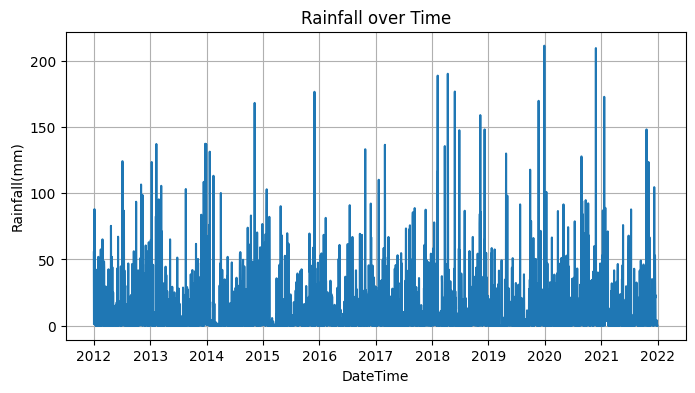

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(weather_data.index, weather_data["Rainfall"])
plt.title(f'Rainfall over Time')
plt.xlabel('DateTime')
plt.ylabel("Rainfall(mm)")
# plt.xlim(pd.Timestamp("2021-02-01"), pd.Timestamp("2022-02-01"))
plt.grid(True)
plt.show()

In [59]:
duplicates = weather_data.index[weather_data.index.duplicated()]
if not duplicates.empty:
    print("Duplicate timestamps found:", duplicates)
    numeric_cols = weather_data.select_dtypes(include=['number']).columns
    non_numeric_cols = weather_data.select_dtypes(exclude=['number']).columns

    # Handle duplicate index by grouping
    # For numeric columns, take the mean
    # For non-numeric columns, take the first occurrence (or other appropriate method)
    weather_data = (
        weather_data.groupby(weather_data.index)
        .agg({**{col: 'mean' for col in numeric_cols},
            **{col: 'first' for col in non_numeric_cols}})
    )
else:
    print("No duplicate timestamps found.")

weather_data

No duplicate timestamps found.


,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2012-01-01,55.4,25.68,26.55,-0.87,81.130435,77.434783,89.043478,6.000000,4.043478,29.816522,68.236934,3.120846,113.024487,24
2012-01-02,1.2,25.68,26.55,-0.87,79.863636,76.454545,89.590909,5.772727,3.727273,29.796364,77.457652,3.120846,113.024487,24
2012-01-03,3.4,25.68,26.55,-0.87,80.333333,76.333333,88.125000,6.000000,4.083333,29.788750,38.298448,3.120846,113.024487,24
2012-01-04,4.2,25.68,26.55,-0.87,78.458333,75.833333,92.208333,6.000000,3.250000,29.810000,111.273322,3.120846,113.024487,24
2012-01-05,88.0,25.68,26.55,-0.87,78.772727,75.272727,89.590909,5.300909,3.545455,29.807273,351.877250,3.120846,113.024487,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.8,25.54,26.60,-1.06,79.666667,74.166667,84.083333,6.000000,3.500000,29.777500,184.722626,3.120846,113.024487,24
2021-12-28,0.0,25.54,26.60,-1.06,80.583333,74.250000,82.666667,6.000000,3.166667,29.755417,111.540951,3.120846,113.024487,24
2021-12-29,0.6,25.54,26.60,-1.06,80.458333,73.666667,81.416667,5.875000,3.125000,29.743750,88.147018,3.120846,113.024487,24


In [62]:
weather_data.to_csv(f"..\data\{folder_path}\{folder_path}-rainfall-daily.csv")